In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
def f(x):
    return 3*x**2 - 4*x + 5

In [30]:
f(3.0)

20.0

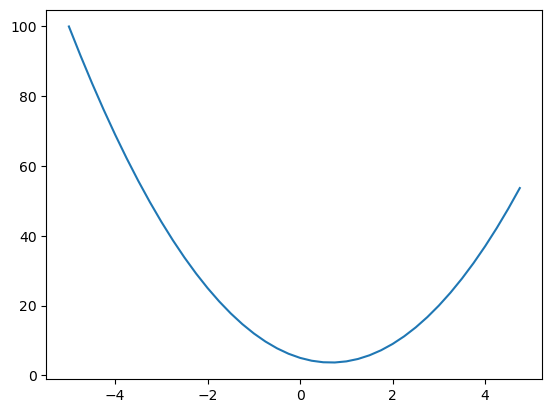

In [31]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [32]:
h = .0001
x = 2/3
(f(x + h) - f(x))/h

0.0002999999981767587

In [33]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [34]:
# take the derivative of the previous function with respect to each variable
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

def g(a, b, c):
    return a * b + c

print('dg/da:', (g(a + h, b, c) - g(a, b, c))/h)
print('dg/db:', (g(a, b + h, c) - g(a, b, c))/h)
print('dg/dc:', (g(a, b, c + h) - g(a, b, c))/h)

dg/da: -3.000000000010772
dg/db: 2.0000000000042206
dg/dc: 0.9999999999976694


In [55]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # gradient
        self._backward = lambda: None # function for backward pass of gradient
        self._prev = set(_children) # set of parent nodes
        self._op = _op # operation used to calculate
        self.label = label # label for the node
    
    def __repr__(self):
        return f"Value(data={self.data})" # used to print object info
    
    def __add__(self, other):
        # Allow for adding of non-Value objects to Value objects
        other = other if isinstance(other, Value) else Value(other) # if other not Value, make it a Value
        out = Value(self.data + other.data, (self, other), '+') # create new Value object

        def _backward():
            # += because the nodes may be attached to multiple others
            self.grad += out.grad # just take on the gradient of the output, since it's addition
            other.grad += out.grad # same
        out._backward = _backward # assign backward function to other node's _backward attribute

        return out
    
    def __neg__(self):
        return self * -1 # return the additive inverse for subtraction purposes
    
    def __sub__(self, other):
        return self + (-other) # add the opposite

    def __mul__(self, other):
        # Allow for multiplication of non-Value objects to Value objects
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            # += because the nodes may be attached to multiple others
            self.grad += other.data * out.grad # multiply gradient by the other data, which we treat as constant
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        # For when the left-side object is not a Value objectk
        return self * other
    
    def __truediv__(self, other):
        return self * other ** -1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Currently only supporting int or float" # make sure data type is correct for power
        out = Value(self.data ** other, (self,), f'**{other}') # create output Value object
        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad # power rule + chain rule
        out._backward = _backward
        return out

    
    def exp(self): # This is e^x, not the exponential function
        x = self.data 
        out = Value(math.exp(x), (self,), 'exp') # Create new object for the output
        def _backward():
            self.grad += out.grad * out.data # e^x is in out, then apply chain rule
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = [] # init list to contain all nodes
        visited = set()
        # recursively build tree by adding node children to queue, adding current node to topo
        # then running build topo on each child in queue
        # note: it's a dfs construction
        def build_topo(v): 
            if v not in visited: 
                visited.add(v)
                for child in v._prev: 
                    build_topo(child) # run build topo on children
                topo.append(v) # add current node to topo
        build_topo(self)

        self.grad = 1.0
        # starting from the very first nodes, run backward function on each
        for node in reversed(topo):
            node._backward()




In [46]:
from graphviz import Digraph

def trace(root):
    # build set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n)) # get mem address of node
        # for any value in graph, create rectangular record node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad, ), shape='record')
        if n._op:
            # if value is result of operation, create op node for it
            dot.node(name=uid+n._op, label=n._op)
            # connect node to value
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        # connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot


In [ ]:
# just for messing around with Value objects
def sandbox():

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)
sandbox()

6.000000000000227


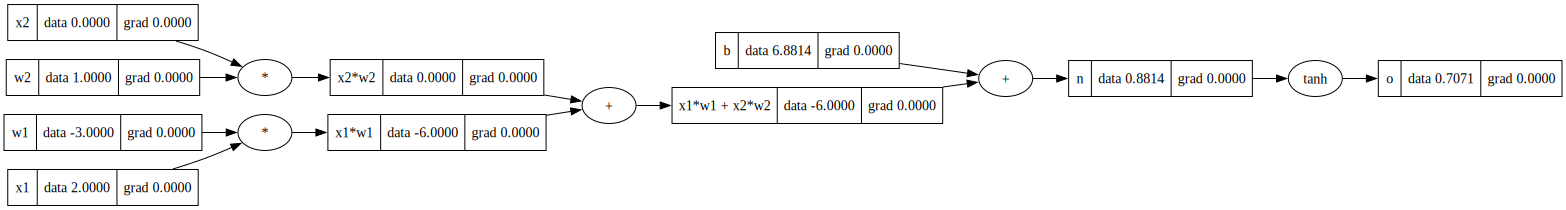

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = "o"
draw_dot(o)

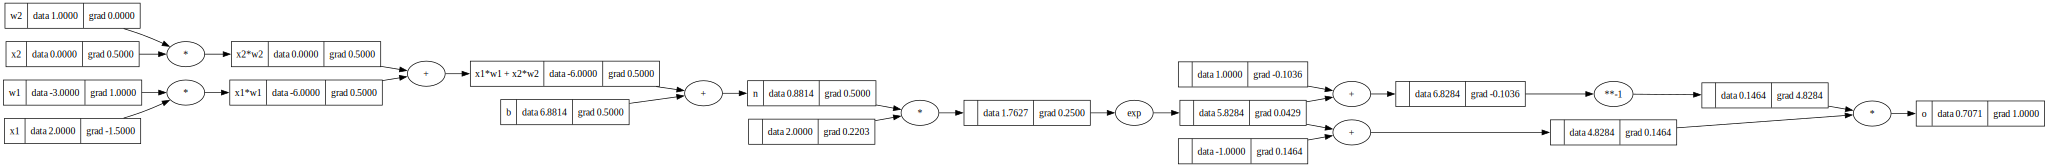

In [56]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = (e - 1) / (e + 1) # n.tanh();
o.label = "o"
o.backward()
draw_dot(o)

In [57]:
# doing the same exact thing but in pytorch
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
